# Kings County Housing Prices Bakeoff

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
from scipy import stats
from math import sin, cos, sqrt, atan2, radians
import pickle

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 200)

### Reading Data Set

In [2]:
df = pd.read_csv('kc_house_data_train.csv')
df

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,17285,627300195,20150303T000000,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,2020,1220,1958,0,98008,47.5858,-122.112,2730,10400
17286,17286,8819900270,20140520T000000,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,1300,0,1948,0,98105,47.6687,-122.288,1350,4013
17287,17287,3816300095,20140514T000000,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,1050,0,1953,0,98028,47.7635,-122.262,1760,9403
17288,17288,122069107,20141204T000000,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,1300,600,1971,0,98038,47.4199,-121.990,2080,108028


### Stats Tests

In [40]:
#H0: price does not change with condition
#H1: price changes with condition
#Reject the null hypothesis
stats.ttest_ind(df['condition'], df['price'], axis=0, equal_var=True, nan_policy='propagate')

Ttest_indResult(statistic=-190.4595808287743, pvalue=0.0)

In [3]:
alpha = .05
stat, p_value = stats.f_oneway(
               df['price'][df['floors']==1],
               df['price'][df['floors']==1.5],
               df['price'][df['floors']==2],
               df['price'][df['floors']==2.5],
               df['price'][df['floors']==3],
               df['price'][df['floors']==3.5])
print('alpha = %.2f, p_value = %.3f' %(alpha, p_value))
if p_value <= alpha:
    print("Reject Null Hypothesis")
else:
    print("Fail to Reject the Null Hypothesis")

alpha = 0.05, p_value = 0.000
Reject Null Hypothesis


### Exploring Data

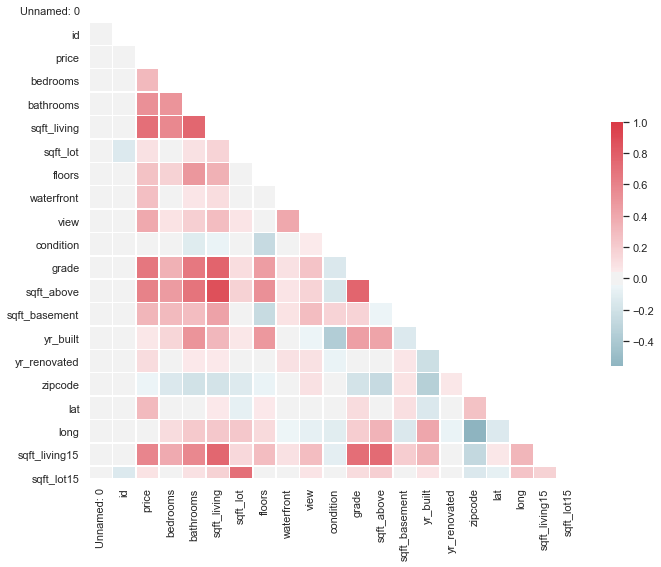

In [4]:
# created a heatmap to see what independent variables have collinearity
# found low collinearity between independent variables
sns.set(style="white")
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [5]:
features = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above','sqft_basement','yr_built',
            'yr_renovated','sqft_living15','sqft_lot15']

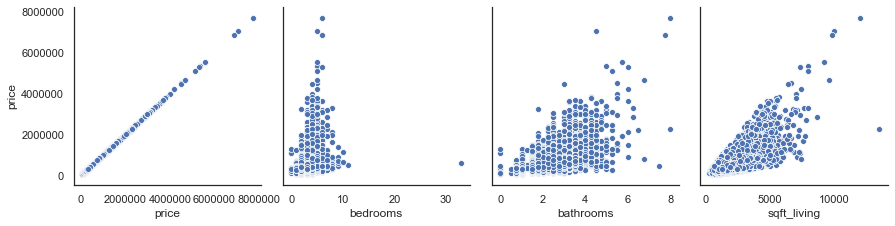

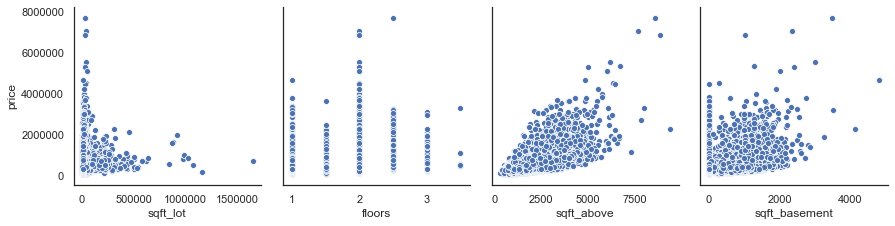

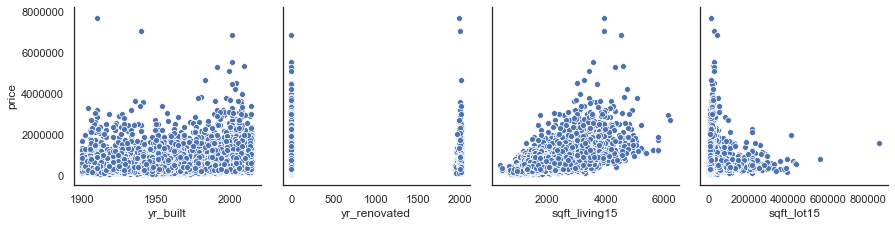

In [6]:
n = 4
row_groups= [features[i:i+n] for i in range(0, len(features), n)]
for i in row_groups:
    pp = sns.pairplot(data=df, y_vars=['price'],x_vars=i, kind="scatter", height=3)

In [7]:
df['date'] = pd.to_datetime(df['date'])

### Cleaning Data

In [8]:
df = df.drop(columns=['Unnamed: 0', 'id'])

In [9]:
df['day_sold'] = pd.to_datetime(df['date']).dt.day
df['month_sold'] = pd.to_datetime(df['date']).dt.month
df['year_sold'] = pd.to_datetime(df['date']).dt.year
df.drop(columns=('date'), inplace=True)

In [10]:
# changing bedrooms & bathrooms to their prespective averages
df['bathrooms'] = df['bathrooms'].replace([0],[1])
df['bedrooms'] = df['bedrooms'].replace([33],[3])

In [11]:
# feature created: has a basement or not
df['basement'] = (df['sqft_basement']> 0)
base_dict = {False: 'No Basement', True: 'Basement'}
df['basement'] = df['basement'].replace(base_dict)

In [12]:
# feature created: difference in square footage of living & lot with living15 & lot15
df['diff_living_15'] = df['sqft_living'] - df['sqft_living15']
df['diff_lot_15'] = df['sqft_lot'] - df['sqft_lot15']

In [13]:
# created feature of total square footage sqft_living + sqft_lot
df['total_sqft'] = df['sqft_living'] + df['sqft_lot']

In [14]:
df['basement'] = df['basement'].replace(['No Basement','Basement'], [0,1])

### Creating Dummy Variables

In [15]:
#created dummy variables with the grade, condition, waterfront, basement and zipcode variables
dummy_df = pd.get_dummies(df, columns=['grade', 'condition','waterfront','basement','zipcode'],drop_first=True)

### Dummy and Continous Variables Interactions

In [16]:
dummy_df['top_5_months'] = (dummy_df['month_sold']>3) & (dummy_df['month_sold']<9)
dummy_df['top_5_months'] = dummy_df['top_5_months'].replace([True, False],[1,0])

In [17]:
#created feature age of the house by subtracting year built and year sold
#created feature years renovated - year sold
#created a categorical feature to see if a house was renovated or not
dummy_df['house_age'] = dummy_df['year_sold'] - dummy_df['yr_built']
dummy_df['yrrenovation_yrsold'] = dummy_df['year_sold'] - dummy_df['yr_renovated']
dummy_df['has_renovation'] = (dummy_df['yrrenovation_yrsold']!=2014) & (dummy_df['yrrenovation_yrsold']!=2015)
dummy_df['has_renovation']= dummy_df['has_renovation'].replace([True,False],[1,0])

In [18]:
features = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'view', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'day_sold',
       'month_sold', 'year_sold', 'diff_living_15', 'diff_lot_15',
       'total_sqft', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7',
       'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13',
       'condition_2', 'condition_3', 'condition_4', 'condition_5',
       'waterfront_1', 'basement_1', 'top_5_months', 'house_age',
       'yrrenovation_yrsold', 'has_renovation']

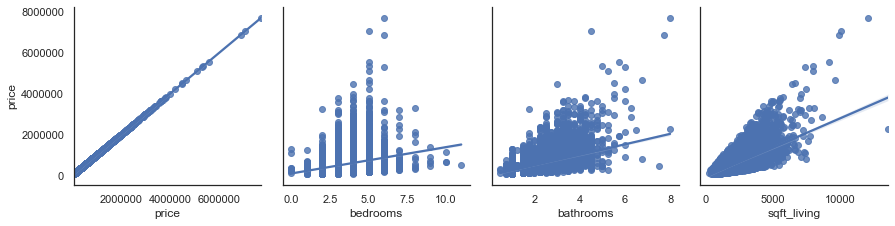

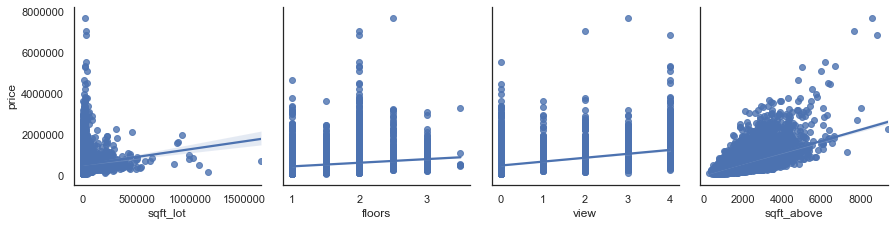

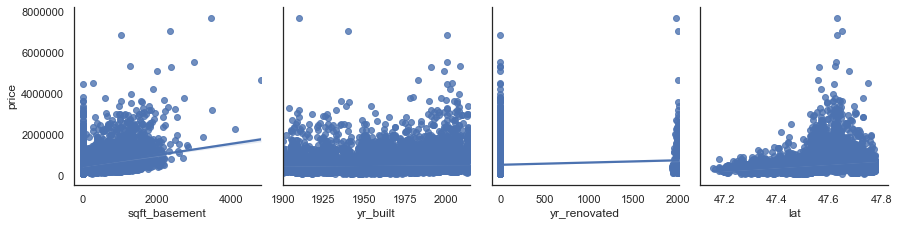

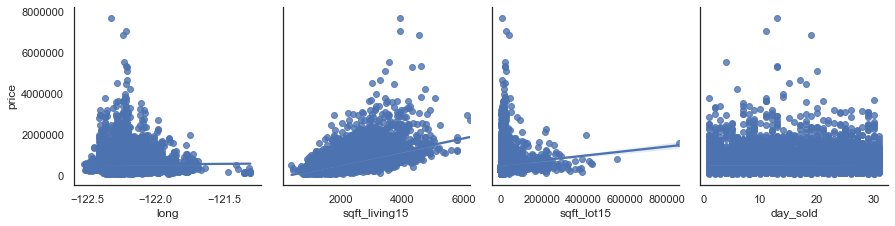

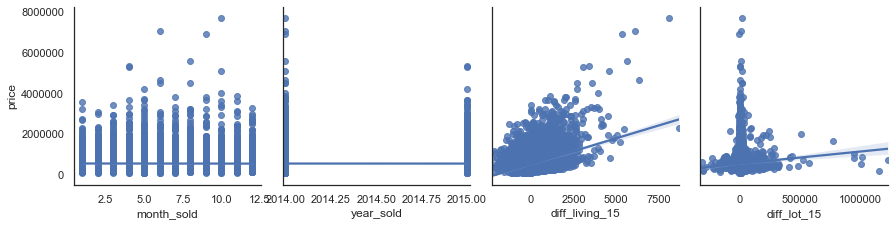

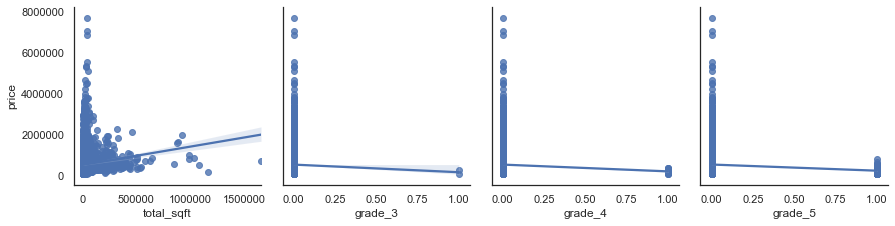

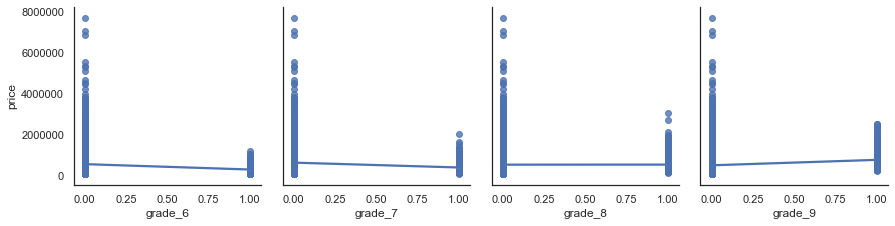

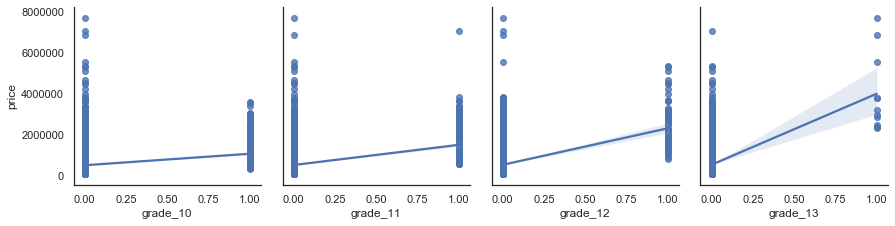

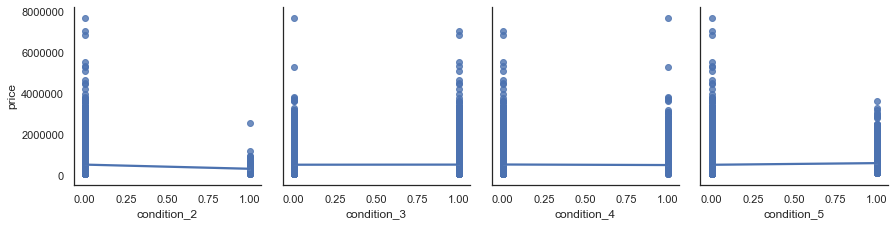

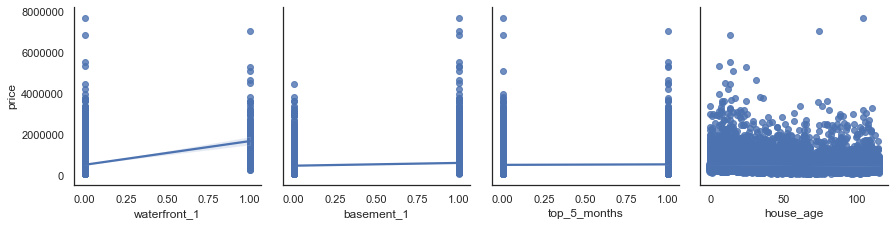

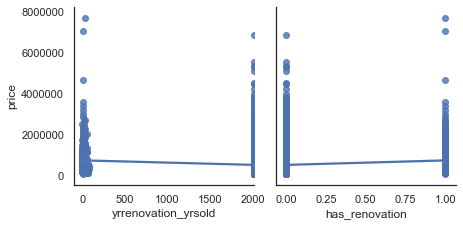

In [19]:
n = 4
row_groups= [features[i:i+n] for i in range(0, len(features), n)]
for i in row_groups:
    graphs = sns.pairplot(data=dummy_df, y_vars=['price'],x_vars=i, kind="reg", height=3)

In [20]:
dummy_df['sqft_living^2']=dummy_df['sqft_living']**2
dummy_df['total_sqft^2']=dummy_df['total_sqft']**2
dummy_df['house_age*yrrenovation_yrsold']=dummy_df['house_age']*dummy_df['yrrenovation_yrsold']

In [21]:
dummy_df['top_5_months*sqft_living'] = dummy_df['top_5_months']*dummy_df['sqft_living']
dummy_df['house_age*has_renovation'] = dummy_df['house_age']*dummy_df['has_renovation']
dummy_df['basement_1*total_sqft'] = dummy_df['basement_1']*dummy_df['total_sqft']
dummy_df['sqft_living_to_lot'] = dummy_df['sqft_lot']/dummy_df['sqft_living']
dummy_df['comparing_living_living15^2'] = (dummy_df['sqft_living']/dummy_df['sqft_living15'])**2
dummy_df['comparing_lot_lot15^2'] = (dummy_df['sqft_lot']/dummy_df['sqft_lot15'])**2

### Train-test split on data

In [23]:
dummy_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,day_sold,month_sold,year_sold,diff_living_15,diff_lot_15,total_sqft,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,condition_2,condition_3,condition_4,condition_5,waterfront_1,basement_1,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,...,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,top_5_months,house_age,yrrenovation_yrsold,has_renovation,sqft_living^2,total_sqft^2,house_age*yrrenovation_yrsold,top_5_months*sqft_living,house_age*has_renovation,basement_1*total_sqft,sqft_living_to_lot,comparing_living_living15^2,comparing_lot_lot15^2
0,365000.0,4,2.25,2070,8893,2.0,0,2070,0,1986,0,0.827963,2.132129,2390,7700,6,10,2014,-320,1193,10963,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,2014,0,4284900,120187369,56392,0,0,0,4.296135,0.750144,1.333875
1,865000.0,5,3.00,2900,6730,1.0,0,1830,1070,1977,0,0.832145,2.134276,2370,6283,21,8,2014,530,447,9630,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,37,2014,0,8410000,92736900,74518,2900,0,9630,2.320690,1.497267,1.147350
2,1038000.0,4,2.50,3770,10893,2.0,2,3770,0,1997,0,0.830159,2.131553,3710,9685,15,8,2014,60,1208,14663,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,17,2014,0,14212900,215003569,34238,3770,0,0,2.889390,1.032607,1.265015
3,1490000.0,3,3.50,4560,14608,2.0,2,4560,0,1990,0,0.832513,2.133281,4050,14226,31,3,2015,510,382,19168,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,2015,0,20793600,367412224,50375,0,0,0,3.203509,1.267709,1.054426
4,711000.0,3,2.50,2550,5376,2.0,0,2550,0,2004,0,0.831906,2.130750,2250,4050,14,7,2014,300,1326,7926,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10,2014,0,6502500,62821476,20140,2550,0,0,2.108235,1.284444,1.762010


In [24]:
features2 = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'day_sold', 'month_sold', 'year_sold', 'diff_living_15', 'diff_lot_15', 'total_sqft', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13', 'condition_2', 'condition_3', 'condition_4', 'condition_5', 'waterfront_1', 'basement_1', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058', 'zipcode_98059', 'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077', 'zipcode_98092', 'zipcode_98102', 'zipcode_98103', 'zipcode_98105', 'zipcode_98106', 'zipcode_98107', 'zipcode_98108', 'zipcode_98109', 'zipcode_98112', 'zipcode_98115', 'zipcode_98116', 'zipcode_98117', 'zipcode_98118', 'zipcode_98119', 'zipcode_98122', 'zipcode_98125', 'zipcode_98126', 'zipcode_98133', 'zipcode_98136', 'zipcode_98144', 'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166', 'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188', 'zipcode_98198', 'zipcode_98199', 'top_5_months', 'house_age', 'yrrenovation_yrsold', 'has_renovation', 'sqft_living^2', 'total_sqft^2', 'house_age*yrrenovation_yrsold', 'top_5_months*sqft_living', 'house_age*has_renovation', 'basement_1*total_sqft', 'sqft_living_to_lot', 'comparing_living_living15^2', 'comparing_lot_lot15^2']


In [25]:
#train test split on dummy_df
X_train, X_test, y_train, y_test = train_test_split(dummy_df[features2],dummy_df['price'] , random_state=34,test_size=0.25)
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (12967, 116) Target:  (12967,)
Training set - Features:  (4323, 116) Target:  (4323,)


### Fitting the model to the training data.

In [26]:
#fitting model to training set
lm = linear_model.LinearRegression()
lm = lm.fit(X_train, y_train)

print(lm.intercept_)
print(lm.coef_)
print("R^2: ", lm.score(dummy_df[features2], dummy_df['price']))

-102096178.51797153
[-2.93391467e+03  2.66331929e+04 -2.25862975e+03  4.74649161e+02
 -1.96538334e+04  4.86543891e+04  7.86789768e+02  7.25341133e+02
  4.06819908e+04  6.29445161e+03  1.06350280e+02 -1.86088773e+03
 -1.16056690e+02  4.24837044e+03  9.60761304e+03  8.63185217e+01
 -1.86073456e+03  1.38614140e+03 -8.82716945e+04 -9.40133024e+04
 -6.99991876e+04 -3.95379810e+04  2.09783935e+03  7.37793626e+04
  1.71500753e+05  2.67244645e+05  6.20637656e+05  1.25727230e+06
  8.34369098e+04  1.04010820e+05  1.34173247e+05  1.85991948e+05
  6.11856125e+05  1.61094369e+04 -1.69576499e+02 -2.28252516e+04
  7.65099836e+05  2.82209566e+05  2.23479926e+05  2.48742373e+05
  2.46566742e+05  4.45073704e+04  1.34204987e+05  9.27252024e+04
  9.19435194e+04 -2.84897445e+04 -3.54902112e+04  1.25247205e+05
  1.54129312e+05  1.35010874e+05  2.05449892e+05  4.29540312e+03
  5.96989407e+03 -3.68816681e+03  3.40918197e+05  2.03899324e+05
  3.10094934e+04  1.16922579e+06  4.87504903e+05 -1.96851278e+03
  9.1

### Prediciting on train and test sets

In [27]:
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

### RMSE on training and test sets

In [28]:
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Training RMSE:' , train_rmse)
print('Testing RMSE:' , test_rmse)

Training RMSE: 144248.5822414145
Testing RMSE: 161618.25445510616


### Over/Under Fitting

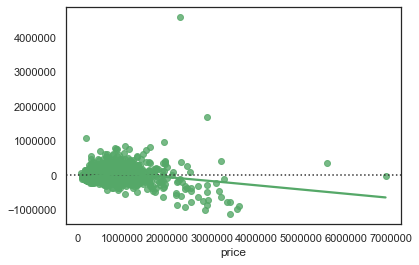

In [29]:
sns.residplot(x = y_test, y= y_test_pred, lowess=True, color = "g")

### Elminating features by RFE

In [30]:
ols = linear_model.LinearRegression()

In [31]:
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
selector.fit(X_train, y_train)

Fitting estimator with 116 features.


RFECV(cv=5,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [32]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

### Running Model on new selected features

In [33]:
lm_rfe = LinearRegression()
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)
y_rfe = lm_rfe.predict(X_train[selected_rfe])
trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))
print('Training Root Mean Squared Error:' , trainRFE_rmse)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])
testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))
print('Testing Root Mean Squared Error:' , testRFE_rmse)

Training Root Mean Squared Error: 144258.31877951004
Testing Root Mean Squared Error: 161709.80068456545


### Comparing Models

In [34]:
print('Original tesing RMSE:' , test_rmse)
print('RFE testing RMSE:' , testRFE_rmse)

Original tesing RMSE: 161618.25445510616
RFE testing RMSE: 161709.80068456545


### Refitting best model to the entire dataset

In [35]:
lm_final = LinearRegression()

#fit the linear regression to the data
lm_final = lm.fit(dummy_df[features2], dummy_df['price'])

### Pickle

In [36]:
pickle_out = open("model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()